# Loading ClimSim

LEAP wide utility for loading in the Climsim dataset efficiently. The actual data lives on [huggingface](https://huggingface.co/datasets/LEAP/ClimSim_low-res_aqua-planet)

Tiers of Access/ [Dataset Information](https://leap-stc.github.io/ClimSim/dataset.html): 
1. High Resolution Data with Geography
2. Low resolution data with geography
3. Low Res aquaplanet
4. Quickstart toy data (subsampled version of low res data)

References : 

- [The Climsim Repo](https://github.com/leap-stc/ClimSim) is the most important resource and contains or links to basically all information.
- Tian assigned her stats class [the challenge of exploring](https://github.com/TZstatsADS/ADS_Teaching/tree/master/16-Fall2023/Projects_StarterCodes/Project3-ClimSim) loading up of the dataset.
- Can see how people did it from the [Kaggle Competition](https://www.kaggle.com/competitions/leap-atmospheric-physics-ai-climsim/code)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm

import gcsfs
fs = gcsfs.GCSFileSystem()
import datetime as dt
import cftime
import json
import fsspec
from tqdm import tqdm
import sys

import dask

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/srv/conda/envs/notebook'
sys.path.append(os.path.abspath(os.path.join('diffusionsim')))
import matplotlib.pyplot as plt

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).

In [2]:
from diffusionsim import mydatasets as data

Diffusers not in workspace, not all models can be loaded


# From Cloud Bucket

Soon to be deprecated, (ClimSim is currently being re-ingested) but for now the easiest way to load the data is from the low-res version in Sungduk's directory. Julius is working on Climsim ingestion right now, so perhaps new and improved versions will exist in leap-persistent bucket

Most utilities for this have been placed in climsim_training_utils.py

In [3]:
ds_in, ds_out = data.load_raw_dataset(chunks = True)

In [4]:
input_vars, output_vars = data.load_vars('v1', tendencies=False)

In [5]:
ds_in, ds_out = data.add_time(ds_in, ds_out)

In [14]:
set(['time', 'ncol']) <= set(ds_in.dims)

True

In [6]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    
    dsi = ds_in[input_vars].to_stacked_array('mli', sample_dims=['sample', 'ncol'])
    dso = ds_out[output_vars].to_stacked_array('mlo', sample_dims=['sample', 'ncol'])

In [10]:
ds_input, ds_output = data.add_space(dsi, dso)

In [9]:
dsi.stack({'state' : ['sample', 'ncol']})

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/util/deprecation_helpers.py:140: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return func(*args, **kwargs)


<xarray.DataArray 'state_t' (mli: 124, state: 80732160)> Size: 80GB
dask.array<reshape, shape=(124, 80732160), dtype=float64, chunksize=(60, 580608), chunktype=numpy.ndarray>
Coordinates:
  * mli       (mli) object 992B MultiIndex
  * variable  (mli) <U11 5kB 'state_t' 'state_t' ... 'pbuf_LHFLX' 'pbuf_SHFLX'
  * lev       (mli) object 992B 0 1 2 3 4 5 6 7 ... 56 57 58 59 nan nan nan nan
  * state     (state) object 646MB MultiIndex
  * sample    (state) int64 646MB 0 0 0 0 0 ... 210239 210239 210239 210239
  * ncol      (state) int64 646MB 0 1 2 3 4 5 6 ... 377 378 379 380 381 382 383

In [36]:
dsi

<xarray.DataArray 'state_t' (time: 210240, ncol: 384, mli: 124)>
dask.array<concatenate, shape=(210240, 384, 124), dtype=float64, chunksize=(1512, 384, 60), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2001-02-01 ... 2009-01-31T23:40:00
  * mli       (mli) object MultiIndex
  * variable  (mli) object 'state_t' 'state_t' ... 'pbuf_LHFLX' 'pbuf_SHFLX'
  * lev       (mli) object 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 nan nan nan nan
Dimensions without coordinates: ncol

### normalizing and saving arrays

In [49]:
input_mean, input_max, input_min, output_scale = data.get_norm_info('nc')


AttributeError: module 'diffusionsim.mydatasets' has no attribute 'get_norm_info'

In [ ]:
ds_input = (ds_input - input_mean)/(input_max - input_min)
ds_target = ds_output*output_scale

In [50]:
from dask.diagnostics import ProgressBar
def ds_to_npy(ds, load=False):
    ds = ds.stack({'sample' : ['time', 'ncol']}) # stacks the time and ncol into one MultiIndex
    ds = ds.to_stacked_array('mlvar', sample_dims=['sample']) # turns the data array of multiple vars into one stacked var
    if(load):
        print(f"{ds.nbytes / 1e9} gigabytes") # GB
        # visualize with progress bar
        with ProgressBar():
            # use .load() or .compute() to do the math and get the daily mean data
            ds.load()
    return(ds)


def save_arrays(X, Y, bucket='scratch', fprefix='climsim'):
    if(bucket== 'scratch'):
        bucket = "leap-scratch"
    elif(bucket == 'persist'):
        bucket = "leap-persistent"
    with fsspec.open(f"gs://{bucket}/sammyagrawal/input_{fprefix}.npy", 'wb') as f:
        np.save(f, X)
    with fsspec.open(f"gs://{bucket}/sammyagrawal/output_{fprefix}.npy", 'wb') as f:
        np.save(f, Y)

## Making Climsim "Images"

In [7]:
from climsim_utils import load_grid_info
ds_grid = load_grid_info('low-res')

In [6]:
pmap = ds_output.isel(sample=10).state_t

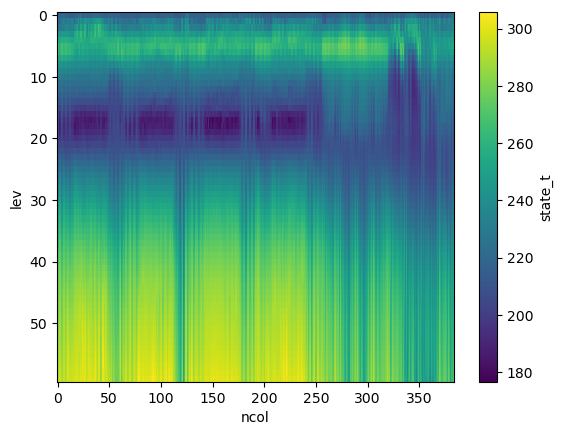

In [7]:
pmap.plot(yincrease=False)

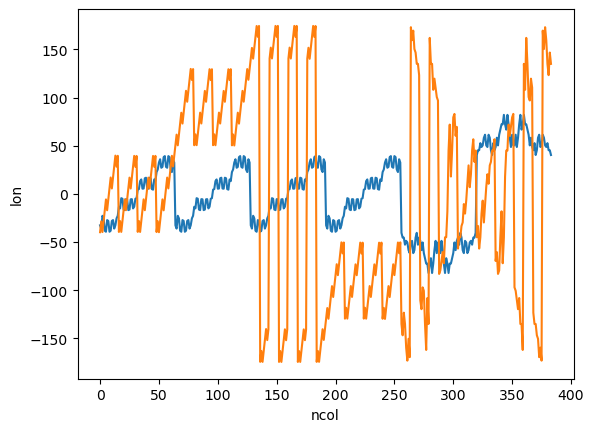

In [8]:
lat, lon = np.round(pmap.lat), np.round(pmap.lon)
pmap.lat.plot()
pmap.lon.plot()

In [9]:
def image_regridding(ds):
    lat, lon = np.round(ds.lat.data), np.round(ds.lon.data)
    array = np.column_stack([lon, lat])
    # first sort by longitude, then by latitude (top is area of high longitude)
    sorted_indices = np.lexsort((array[:, 0], -1*array[:, 1]))
    arr = array[sorted_indices]
    indices = np.array([], dtype=int)
    for i in range(16):
        start = i*24
        indices = np.concatenate([indices, start + np.argsort(arr[start:start+24, 0])])

    return(sorted_indices[indices])

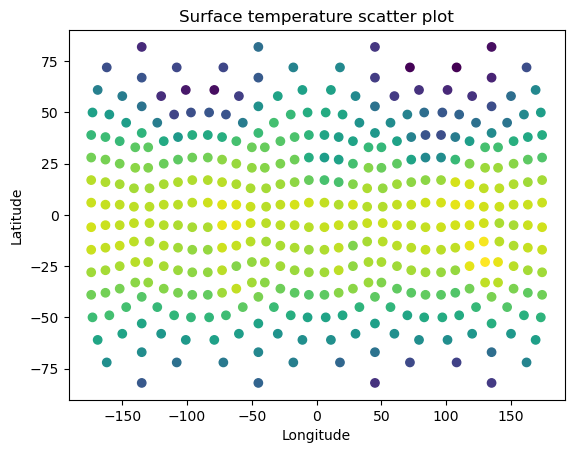

In [18]:
plt.scatter(lon, lat, c=pmap.sel(lev=59).values)
plt.title("Surface temperature scatter plot")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [38]:
ds = ds_input
lat, lon = np.round(ds.lat.data), np.round(ds.lon.data)
array = np.column_stack([lon, lat])
# first sort by longitude, then by latitude (top is area of high longitude)
sorted_indices = np.lexsort((array[:, 0], -1*array[:, 1]))
arr = array[sorted_indices]
indices = np.array([], dtype=int)
for i in range(16):
    start = i*24
    indices = np.concatenate([indices, start + np.argsort(arr[start:start+24, 0])])

t = sorted_indices[indices]

In [39]:
#arr[indices, 0].reshape(16, 24)

In [40]:
test = image_regridding(ds_input)

In [41]:
xv, yv = np.meshgrid(np.unique(lon), np.unique(lat))

In [46]:
temps = pmap.sel(lev=59).values
coord = list(zip(np.round(pmap.lat.values), np.round(pmap.lon.values)))

In [47]:
grid = array[t].reshape(16, 24, 2)

In [48]:
map_vals = np.zeros_like(xv)
map_vals

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
for index, (lat, lon) in enumerate(coord):
    i, j = np.where(np.unique(lat)==lat)[0][0], np.where(np.unique(lon) == lon)[0][0]
    map_vals[i, j] = temps[index]

In [53]:
yv

array([[-82., -82., -82., ..., -82., -82., -82.],
       [-72., -72., -72., ..., -72., -72., -72.],
       [-67., -67., -67., ..., -67., -67., -67.],
       ...,
       [ 67.,  67.,  67., ...,  67.,  67.,  67.],
       [ 72.,  72.,  72., ...,  72.,  72.,  72.],
       [ 82.,  82.,  82., ...,  82.,  82.,  82.]])

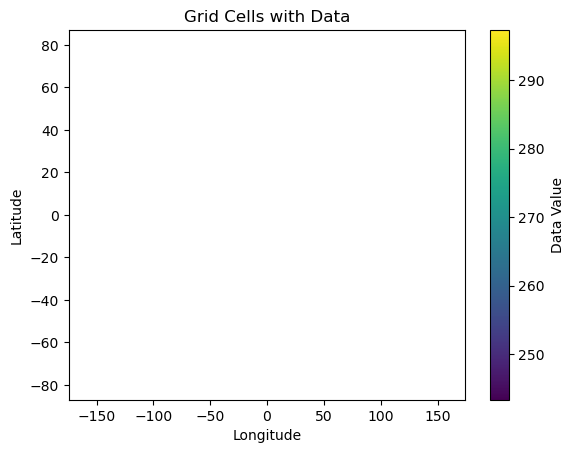

In [51]:
masked_data = np.ma.masked_where(map_vals == 0, map_vals)

plt.pcolormesh(xv, yv, masked_data, cmap='viridis')
plt.colorbar(label='Data Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grid Cells with Data')
plt.show()

In [54]:
temp_map = pmap[:, t].sel(lev=59).values.reshape(16, 24)

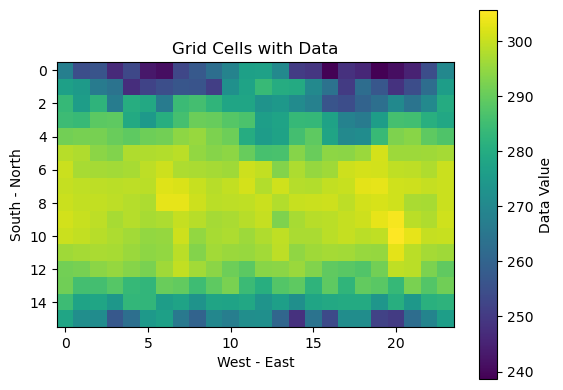

In [55]:
plt.imshow(temp_map, cmap='viridis')
plt.colorbar(label='Data Value')
plt.xlabel('West - East')
plt.ylabel('South - North')
plt.title('Grid Cells with Data')
plt.show()

(array([  6.,  12.,  16.,  13.,  27.,  38.,  39.,  47., 119.,  67.]),
 array([238.59647127, 245.308874  , 252.02127674, 258.73367947,
        265.44608221, 272.15848494, 278.87088768, 285.58329041,
        292.29569315, 299.00809589, 305.72049862]),
 <BarContainer object of 10 artists>)

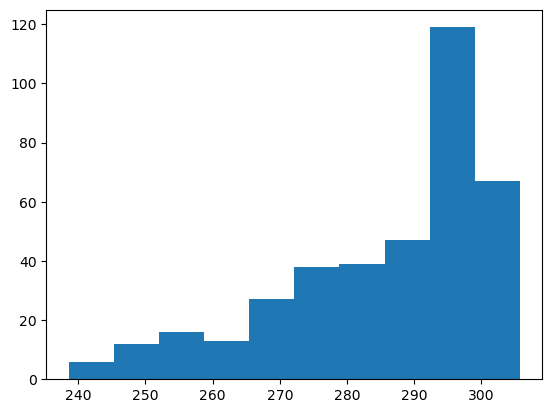

In [21]:
plt.hist(pmap.sel(lev=59))

# Streaming Zarr to Batches

In [165]:
import xbatcher
import torch
from torch import multiprocessing
from torch.utils.data import DataLoader

from dataclasses import dataclass, asdict, field
from typing import List, Dict, Tuple, Optional
from typing_extensions import Annotated
import typer

import time

In [189]:
@dataclass
class DataConfig:
    chunksize: Dict = field(default_factory=lambda : {})
    shuffle: bool = False
    batch_size: int = 32
    num_workers: int = 4
    prefetch_factor: int = 3
    persistent_workers: int = 4
    pin_memory: bool = False,
    train_step_time: Annotated[Optional[float], typer.Option()] = 0.1,
    dask_threads: Annotated[Optional[int], typer.Option()] = None,
    dask_scheduler: str = 'threaded'
    bg_input_dims: Dict = field(default_factory=lambda : dict(time=32, ncol=384))

params = DataConfig()

In [117]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds_in = xr.open_dataset(mapper, engine='zarr', chunks={})
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_out = xr.open_dataset(mapper, engine='zarr', chunks={})

ds_in, ds_out = ds_in.rename({'sample':'time'}), ds_out.rename({'sample':'time'})

In [118]:
input_vars, output_vars = data.load_vars('v1', tendencies=False)

In [131]:
dsi, dso = data.add_space(ds_in[input_vars], ds_out[output_vars])

In [132]:
## Applying image transforms
permute_indices = data.image_regridding(dso)
dsi = dsi.isel(ncol=permute_indices)
dso = dso.isel(ncol=permute_indices)

In [133]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsi = dsi.to_stacked_array('mli', sample_dims=['time', 'ncol'])
    dso = dso.to_stacked_array('mlo', sample_dims=['time', 'ncol'])
    dsi, dso = dsi.transpose('time', 'mli', 'ncol'), dso.transpose('time', 'mlo', 'ncol')

In [122]:
print(f"input ds:{dsi.nbytes / 1e9} GB, output ds:{dso.nbytes / 1e9} gb")

input ds:80.08630272 GB, output ds:82.66973184 gb


In [134]:
dso

<xarray.DataArray 'state_t' (time: 210240, mlo: 128, ncol: 384)> Size: 83GB
dask.array<transpose, shape=(210240, 128, 384), dtype=float64, chunksize=(1512, 60, 384), chunktype=numpy.ndarray>
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

In [135]:
bgen = xbatcher.BatchGenerator(dso, input_dims=params.bg_input_dims)

In [136]:
%%time
batch = bgen[0]

CPU times: user 1.94 s, sys: 894 ms, total: 2.83 s
Wall time: 2.4 s


In [151]:
batch.data.shape

(32, 128, 384)

In [161]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def print_json(log):
    pass
    
class XBatcherPyTorchDataset(torch.utils.data.Dataset):
    def __init__(self, batch_generator: xbatcher.BatchGenerator):
        self.bgen = batch_generator

    def __len__(self):
        return len(self.bgen)

    def __getitem__(self, idx):
        t0 = time.time()
        print_json({
                "event": "get-batch start",
                "time": t0,
                "idx": idx,
                "pid": multiprocessing.current_process().pid,})
        # load before stacking
        batch = self.bgen[idx].load()

        # Use to_stacked_array to stack without broadcasting,
        #stacked = batch.to_stacked_array(
        #    new_dim="batch", sample_dims=("time", "longitude", "latitude")
        #).transpose("time", "batch", ...)
        x = torch.tensor(batch.data.reshape(-1, 128, 16, 24))
        t1 = time.time()
        print_json({
                "event": "get-batch end",
                "time": t1,
                "idx": idx,
                "pid": multiprocessing.current_process().pid,
                "duration": t1 - t0,})
        return x

In [166]:
dataset = XBatcherPyTorchDataset(bgen)

In [168]:
%%time
dataset[10].shape

CPU times: user 2.12 s, sys: 770 ms, total: 2.89 s
Wall time: 2.47 s


torch.Size([32, 128, 16, 24])

In [183]:
import multiprocessing

In [227]:
@dataclass
class DataConfig:
    chunksize: Dict = field(default_factory=lambda : {})
    shuffle: bool = False
    batch_size: int = 1
    num_workers: int = 0
    prefetch_factor: int = None
    persistent_workers: bool = False
    pin_memory: bool = False
    train_step_time: Annotated[Optional[float], typer.Option()] = 0.1
    dask_threads: Annotated[Optional[int], typer.Option()] = None
    dask_scheduler: str = 'single-threaded'
    bg_input_dims: Dict = field(default_factory=lambda : dict(time=32, ncol=384))
    multiprocessing_context:str = None

params = DataConfig()

In [228]:
if params.num_workers:
    params.multiprocessing_context = multiprocessing.get_start_method()
    params.multiprocessing_context = "forkserver" 

In [229]:
dask.config.set(scheduler=params.dask_scheduler)

dataloader = DataLoader(
    ds, shuffle=params.shuffle, num_workers=params.num_workers, 
    multiprocessing_context= params.multiprocessing_context, prefetch_factor=params.prefetch_factor,
    persistent_workers=params.persistent_workers, pin_memory=params.pin_memory
)
                        

In [230]:
%%time
batch = next(iter(dataloader))
batch.shape

CPU times: user 2.57 s, sys: 1.08 s, total: 3.64 s
Wall time: 5.13 s


torch.Size([1, 32, 128, 16, 24])

In [225]:
def main():
    for epoch in range(num_epochs):
        e0 = time.time()
        print_json({"event": "epoch start", "epoch": epoch, "time": e0})

        for i, sample in enumerate(training_generator):
            tt0 = time.time()
            print_json({"event": "training start", "batch": i, "time": tt0})
            time.sleep(train_step_time)  # simulate model training
            tt1 = time.time()
            print_json({"event": "training end", "batch": i, "time": tt1, "duration": tt1 - tt0})
            if i == num_batches - 1:
                break

        e1 = time.time()
        print_json({"event": "epoch end", "epoch": epoch, "time": e1, "duration": e1 - e0})

### Manual Speed tests

In [170]:
dso

<xarray.DataArray 'state_t' (time: 210240, mlo: 128, ncol: 384)> Size: 83GB
dask.array<transpose, shape=(210240, 128, 384), dtype=float64, chunksize=(1512, 60, 384), chunktype=numpy.ndarray>
Coordinates:
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
Dimensions without coordinates: time

In [172]:
import time
import random
manual = dict(times=[], batches=[])
xbatch = dict(times=[], batches=[])
sizes = [1, 2, 4, 8, 16, 32, 64, 128]
for sz in sizes:
    print(f"Loading batch size {sz}")
    idx = random.randint(0, 1000)
    bgen = xbatcher.BatchGenerator(dso, input_dims=dict(ncol=384,mlo=128,time=sz))
    now = time.time()
    batch = bgen[idx].load()
    xbatch['times'].append(time.time() - now)
    xbatch['batches'].append(batch)
    
    now = time.time()
    start = int(idx*sz)
    batch = dso.isel(time=slice(start, start+sz))
    batch.load()
    manual['times'].append(time.time() - now)
    manual['batches'].append(batch)

Loading batch size 1
Loading batch size 2
Loading batch size 4
Loading batch size 8
Loading batch size 16
Loading batch size 32
Loading batch size 64
Loading batch size 128


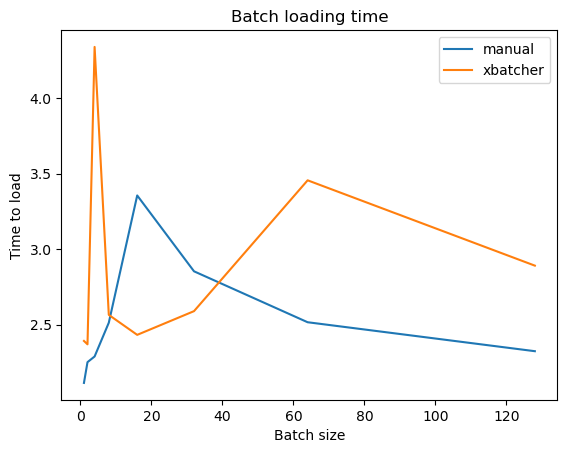

In [175]:
plt.plot(sizes, manual['times'], label='manual')
plt.plot(sizes, xbatch['times'], label='xbatcher')
plt.legend()
plt.xlabel("Batch size")
plt.ylabel("Time to load")
plt.title("Batch loading time")
plt.show()

#### Optimizing using distributed sampling, dask, and xbatcher

Factors of variation: 
- dask batch chunking and how computation graph was setup
- Once dask graph is setup, it is run using a [scheduler](https://docs.dask.org/en/stable/scheduler-overview.html) in which various levels of parallelism can be implemented.
- The number of workers assigned to both dask and xbatcher. Optimality depends on hardware and time for each task
- Sampling and torch dataset/dataloader configs


Resources: 
[Dask chunk sizing guidelines](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes)

### Dask Rechunking tests

In [46]:
print(210240 / (64 * 9 * 5))
64 * 9 * 5

73.0


2880

In [43]:
dso_chunked = dso.chunk({'sample':1440, 'mlo':128})
dso_chunked

<xarray.DataArray 'state_t' (sample: 210240, ncol: 384, mlo: 128)> Size: 83GB
dask.array<rechunk-merge, shape=(210240, 384, 128), dtype=float64, chunksize=(1440, 384, 128), chunktype=numpy.ndarray>
Coordinates:
  * mlo       (mlo) object 1kB MultiIndex
  * variable  (mlo) <U14 7kB 'state_t' 'state_t' ... 'cam_out_SOLLD'
  * lev       (mlo) object 1kB 0 1 2 3 4 5 6 7 ... nan nan nan nan nan nan nan
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
    lon       (ncol) float64 3kB dask.array<chunksize=(384,), meta=np.ndarray>
Dimensions without coordinates: sample

In [42]:
dso_chunked.chunksizes

Frozen({'sample': (1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440), 'ncol': (384,), 'mlo': (128,)})

In [ ]:
dso

### xbatcher

[Demo and tutorial](https://xbatcher.readthedocs.io/en/latest/tutorials-and-presentations.html)

In [30]:
params.batch_size = 32

In [62]:
dso_unstack = dso.unstack('mlo')
dso_unstack

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/util/deprecation_helpers.py:140: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing `

<xarray.DataArray 'state_t' (time: 210240, ncol: 384, variable: 10, lev: 60)> Size: 388GB
dask.array<reshape, shape=(210240, 384, 10, 60), dtype=float64, chunksize=(1512, 384, 9, 60), chunktype=numpy.ndarray>
Coordinates:
  * variable  (variable) <U14 560B 'cam_out_FLWDS' 'cam_out_NETSW' ... 'state_t'
  * lev       (lev) object 480B 0 1 2 3 4 5 6 7 8 ... 51 52 53 54 55 56 57 58 59
  * ncol      (ncol) int64 3kB 373 359 358 357 356 353 ... 283 281 282 280 266
    lat       (ncol) float64 3kB 61.44 72.29 66.73 ... -82.06 -72.29 -61.44
    lon       (ncol) float64 3kB -169.5 -161.9 -135.0 ... 135.0 161.9 169.5
Dimensions without coordinates: time

In [72]:
bgen = xbatcher.BatchGenerator(
        dso, batch_dims=dict(time=params.batch_size),
        #input_overlap=overlap,
        #preload_batch=False,
    )

In [73]:
next(iter(bgen))

ValueError: cannot create a multi-index along stacked dimension 'sample' from variable 'mlo' that wraps a multi-index

## Using modified Climsim Data Utils

I changed the [original climsim data processing file](https://github.com/leap-stc/ClimSim/blob/main/climsim_utils/data_utils.py) to be workable with huggingface data (currently too slow because of lack of virtualization), local filesystem (which is what it's designed for), or from google cloud bucket (if we ingest again without solving copy_to_local) 

- Main motivation is retaining format for standardized evaluation
- Need to assess once we figure out the ideal pipeline

#### Check which variables are included & their dimensions/shapes 

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).

In [ ]:
from climsim_utils import setup_data_utils, tocft, expand_ds_name
data = setup_data_utils(ds_type='aquaplanet', data_source="hf", data_vars='v1')

In [ ]:
data.set_filelist_using_intervals("train", tocft(1, 2, 1), tocft(1, 2, 5), 60*4)

In [ ]:
files = data.get_filelist('train')

In [ ]:
ds_input, ds_output = data.get_input(files[0]), data.get_target(files[1])

In [ ]:
ds_input

In [ ]:
dsi = ds_input.stack({'batch':{'ncol'}})
dsi.to_stacked_array('mlvar', sample_dims=['batch'], name='mli')

In [ ]:
ds_input = ds_input.stack({'batch':{'ncol'}})
ds_input = ds_input.to_stacked_array('mlvar', sample_dims=['batch'], name='mli')
# dso = dso.stack({'batch':{'sample','ncol'}})
ds_target = ds_target.stack({'batch':{'ncol'}})
ds_target = ds_target.to_stacked_array('mlvar', sample_dims=['batch'], name='mlo')
yield (ds_input.values, ds_target.values)

In [ ]:
dataset = data.load_ncdata_with_generator("train")
dataset

# Loading From Huggingface Directly

Inspired by [Charles feedstock](https://github.com/leap-stc/climsim_feedstock/blob/c9143502c098869519ed04a7238e487001b7a46b/feedstock/recipe.py#L206-L208)

In [3]:
#!pip install datasets

In [5]:
#from datasets import load_dataset

## Aquaplanet

In [6]:
from climsim_utils import *

In [9]:
start = tocft(1, 2, 1)
stop = tocft(1, 2, 2)
interval = dt.timedelta(minutes=120)

In [10]:
input_ds, output_ds = load_climsim(start, stop, interval)

Loading 12.0 time files from ClimSim_low-res_aqua-planet


100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'climsim_variable_metadata.json'

In [43]:
input_ds

<xarray.Dataset> Size: 23MB
Dimensions:           (time: 12, ncol: 384, lev: 60)
Coordinates:
  * time              (time) object 96B 0001-02-01 00:00:00 ... 0001-02-01 22...
    lat               (ncol) float64 3kB -32.59 -35.99 -22.69 ... 45.34 40.39
    lon               (ncol) float64 3kB -39.73 -28.47 -39.56 ... 146.7 135.0
Dimensions without coordinates: ncol, lev
Data variables: (12/27)
    cam_in_ALDIF      (time, ncol) float64 37kB 1.0 1.0 1.0 ... 0.06 0.06 0.06
    cam_in_ALDIR      (time, ncol) float64 37kB 1.0 1.0 1.0 ... 0.1077 0.1603
    cam_in_ASDIF      (time, ncol) float64 37kB 1.0 1.0 1.0 ... 0.06 0.06 0.06
    cam_in_ASDIR      (time, ncol) float64 37kB 1.0 1.0 1.0 ... 0.1077 0.1603
    cam_in_ICEFRAC    (time, ncol) float64 37kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cam_in_LANDFRAC   (time, ncol) float64 37kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                ...
    state_t           (time, lev, ncol) float64 2MB 230.7 232.4 ... 273.4 279.0
    state_u           (time, lev, ncol) float64 2MB 8.953 2.413 ... -3.439
    state_v           (time, lev, ncol) float64 2MB -5.276 -6.733 ... 6.386
    pbuf_CH4          (time, lev, ncol) float64 2MB 1.556e-07 ... 9.114e-07
    pbuf_N2O          (time, lev, ncol) float64 2MB 2.565e-08 ... 4.648e-07
    pbuf_ozone        (time, lev, ncol) float64 2MB 7.321e-07 ... 4.882e-08
Attributes:
    ne:        4
    fv_nphys:  2
    calendar:  NO_LEAP

In [50]:
import shutil
shutil.rmtree("gs://leap-scratch/sammyagrawal/aquaplanet_out_1.zarr", ignore_errors=True)

In [64]:

path = "gs://leap-scratch/sammyagrawal"
input_ds.to_zarr("gs://leap-scratch/sammyagrawal/aquaplanet_in_3.zarr")
output_ds.to_zarr("gs://leap-scratch/sammyagrawal/aquaplanet_out_3.zarr")

# Experimenting With Loaded Data

In [ ]:
def load_latlon():
    mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
    ds_grid = xr.open_dataset(mapper, engine='zarr')
    lat = ds_grid.lat.values.round(2) 
    lon = ds_grid.lon.values.round(2)  
    return(lat, lon)
lat, lon = load_latlon()
print(list(zip(lat, lon))[:5])

f = lambda row : row.lat > 50

def select_region(condition):
    # assumes condition is a lambda function taking in a lat and lon
    # returns the indices for which this is true
    lat, lon = load_latlon()
    latlon = pd.DataFrame({"lat" : lat, "lon": lon})
    return(list(latlon[latlon.apply(condition, axis=1)].index))

def split_ds_by_area(ds, condition):
    match = select_region(condition)
    unmatch = select_region(lambda row : not condition(row))
    return(ds.isel(ncol=match), ds.isel(ncol=unmatch))

In [ ]:
lat, lon = load_latlon()

f = lambda row : row.lat > 50
train, test = split_ds_by_area(ds, f)

### Xarray --> Dataset

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
def normalize_xarr(ds_input, ds_output):
    input_mean = xr.open_dataset('Climsim_info/input_mean.nc')
    input_max = xr.open_dataset('Climsim_info/input_max.nc')
    input_min = xr.open_dataset('Climsim_info/input_min.nc')
    output_scale = xr.open_dataset('Climsim_info/output_scale.nc')

    ds_in = (ds_input - input_mean)/(input_max - input_min)
    ds_target = ds_output*output_scale

    return(ds_in, ds_target)

In [ ]:
user_path = "gs://leap-scratch/sammyagrawal"  # 👀 make sure to prepend `gs://` to the path or xarray will interpret this as a local path
#store_name = "processed_store.zarr"
#ds_processed.to_zarr(f"{user_path}/{store_name}")

with fs.open(os.path.join(user_path, "input_climsim.npy"), 'wb') as f:
    np.save(f, input_npy)

with fs.open(os.path.join(user_path, "output_climsim.npy"), 'wb') as f:
    np.save(f, output_npy)

In [ ]:
class ClimsimDataset(Dataset):
    def __init__(self, input_npy, output_npy):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.X = torch.tensor(input_npy, device=self.device, dtype=torch.float32)
        self.Y = torch.tensor(output_npy, device=self.device, dtype=torch.float32)
        assert self.X.shape[0] == self.Y.shape[0], "Number of samples does not match"

    def __len__(self):
        return(X.shape[0])

    def __item__(self, idx):
        return(self.X[idx], self.Y[idx])

In [ ]:
train_ds = ClimsimDataset(input_npy, output_npy)

In [ ]:
%%time
train_ds[5]